# Siemens Energy Coding Challenge - Task 2 - 2021 - Sam MacIntyre

This jupyter notebook contains the code related to task 1, the jupyter notebook follows the structure below:

- Task outline
- Environment and version control
- Problem approach
- Data and library loading
- Data exploration and summary statistics
- Low variance removal
- Dimensionality reduction
- Linear regression
- Random Forest
- XGBoost
- Lagging variables

## Task outline

Condition monitoring is crucial to prevent equipment failures, optimize maintenance timing and assess intervention benefits.
In this task you will have to forecast the remaining useful life of the components given their current status at the end of the timeseries.

The data set consists of multiple multivariate time series.
Each time series is from a different engine, but the data can be considered to be from a fleet of engines of the same type.
Each engine starts with different degrees of initial wear and manufacturing variation which is unknown but still considered normal, i.e. not a fault condition.
Each engine operates at similar ambient conditions and evolves towards only one kind of failure.
There are three operational settings that have a substantial effect on engine performance.
These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series.
In the training set, the fault grows in magnitude until system failure.
In the test set, the time series ends some time prior to system failure.
The objective is to predict the number of remaining operational cycles before failure in the test set, i.e. the number of operational cycles after the last cycle that the engine will continue to operate.

The data are provided as a text file with 26 columns of numbers, separated by spaces.
Each row is a snapshot of data taken during a single operational cycle, each column is a different variable.
The columns correspond to:

1)	unit number

2)	time, in cycles

3)	operational setting 1

4)	operational setting 2

5)	operational setting 3

6)	sensor measurement  1

7)	sensor measurement  2
...
26)	sensor measurement  21

You should build a machine learning algorithm able to predict the remaining useful cycles and then try to answer some questions:
1. How would you change your approach if instead of similar ambient conditions we would have six different climates?
2. What if we had an additional possible kind of failure? How would you approach the problem then?

## Environment and version control

A temporary Github repository will be used to employ version control and protect against loss of code. Furthermore, a standard Python3 venv has been set up to ensure a clean and reproducible coding environment.

## Problem approach

- Aim is to **predict** the number of operational cycles (after the last cycle) that the engine will operate until failure
- Assume system failure has been achieved at end of time series in test set


This type of problem is known as RUL prediction and has been studied quite extensively. 

## Data and library loading

In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [235]:
# Load training dataset
df_train = pd.read_csv('data/Task 2/train_FD001.txt', sep = " ", header = None)

In [236]:
# Load testing dataset
df_test = pd.read_csv('data/Task 2/test_FD001.txt', sep = " ", header = None)

In [237]:
# Explore data
df_test

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,NaN,NaN
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,NaN,NaN
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,NaN,NaN
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,NaN,NaN


In [238]:
# rename columns
df_train.rename(columns = {0:"unit", 1: "time (cycles)", 2:"O1", 3:"O2", 4:"O3"}, inplace = True)
df_test.rename(columns = {0:"unit", 1: "time (cycles)", 2:"O1", 3:"O2", 4:"O3"}, inplace = True)

In [239]:
df_train.columns

Index([         'unit', 'time (cycles)',            'O1',            'O2',
                  'O3',               5,               6,               7,
                     8,               9,              10,              11,
                    12,              13,              14,              15,
                    16,              17,              18,              19,
                    20,              21,              22,              23,
                    24,              25,              26,              27],
      dtype='object')

In [240]:
df_test

,unit,time (cycles),O1,O2,O3,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,NaN,NaN
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,NaN,NaN
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,NaN,NaN
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,NaN,NaN


In [241]:
df_train.describe()

,unit,time (cycles),O1,O2,O3,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,0.0,0.0
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,NaN,NaN
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251,NaN,NaN
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,NaN,NaN
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,NaN,NaN
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,NaN,NaN
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,NaN,NaN
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,NaN,NaN


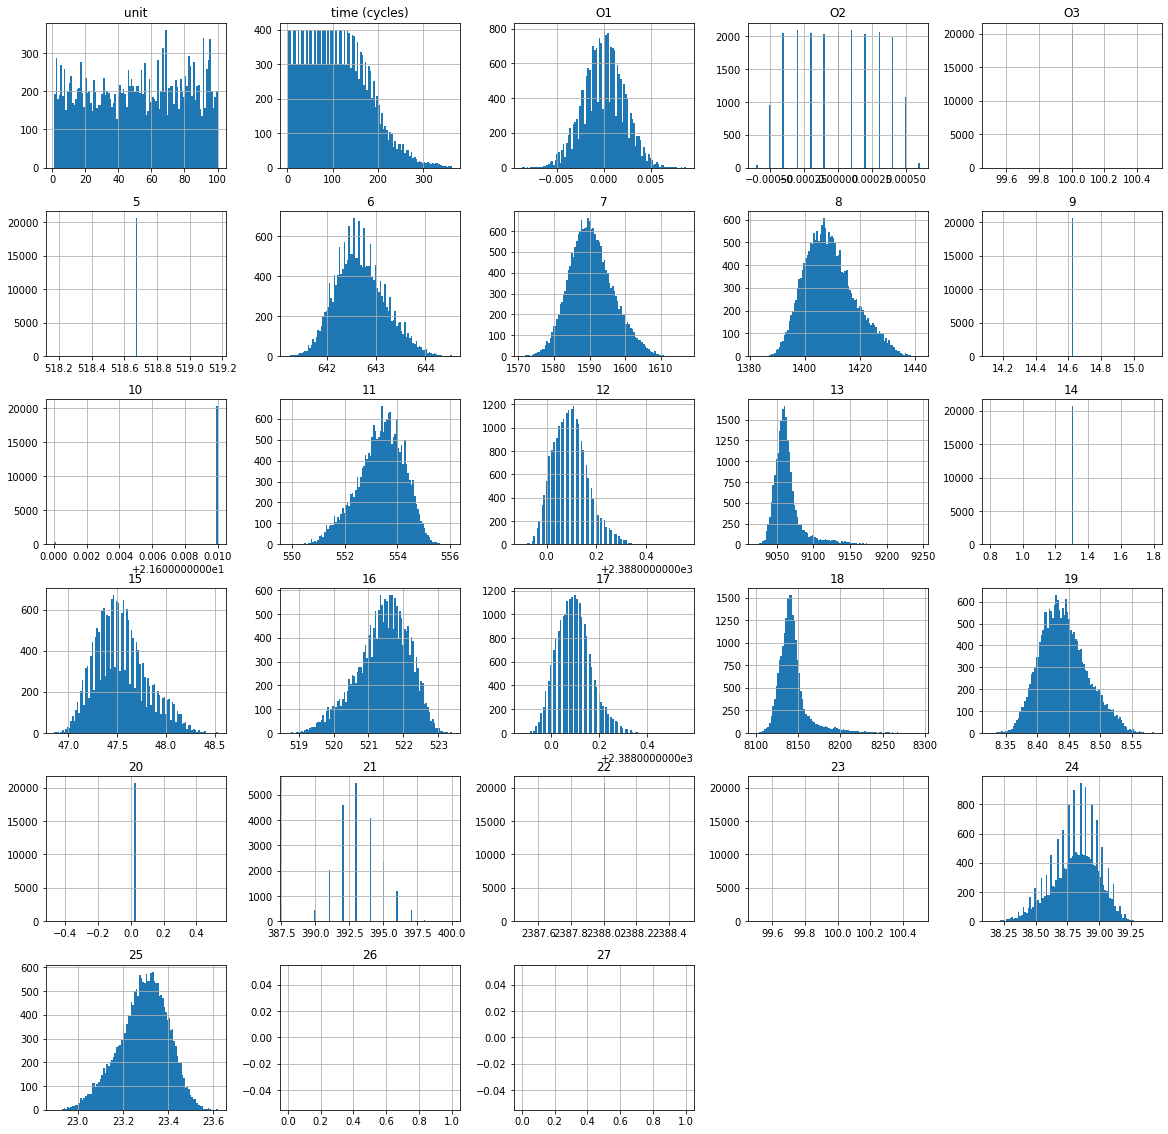

In [242]:
# Distributions of different variables
df_train.hist(bins = 100, figsize=(20,20));

Main takeaways from above:
- Some non-existent variables and some that vary very little
- Some sensors display relatively normal distributions
- Operation condition 2 possibly only has discrete values and could be turned into an ordinal variable

count    100.000000
mean     206.310000
std       46.342749
min      128.000000
25%      177.000000
50%      199.000000
75%      229.250000
max      362.000000
Name: time (cycles), dtype: float64

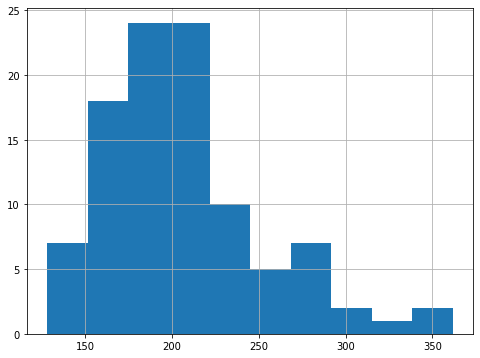

In [243]:
# Distribution of failure times
t_failure = df_train.groupby('unit').max()['time (cycles)']
t_failure.hist(figsize = (8,6))
t_failure.describe()

- Mean time to failure time is around 206 cycles
- Distribution is skewed to the right

In [244]:
df_train.loc[df_train.unit == 2]

,unit,time (cycles),O1,O2,O3,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
192,2,1,-0.0018,0.0006,100.0,518.67,641.89,1583.84,1391.28,14.62,...,8137.72,8.3905,0.03,391,2388,100.0,38.94,23.4585,NaN,NaN
193,2,2,0.0043,-0.0003,100.0,518.67,641.82,1587.05,1393.13,14.62,...,8131.09,8.4167,0.03,392,2388,100.0,39.06,23.4085,NaN,NaN
194,2,3,0.0018,0.0003,100.0,518.67,641.55,1588.32,1398.96,14.62,...,8140.58,8.3802,0.03,391,2388,100.0,39.11,23.4250,NaN,NaN
195,2,4,0.0035,-0.0004,100.0,518.67,641.68,1584.15,1396.08,14.62,...,8140.44,8.4018,0.03,391,2388,100.0,39.13,23.5027,NaN,NaN
196,2,5,0.0005,0.0004,100.0,518.67,641.73,1579.03,1402.52,14.62,...,8136.67,8.3867,0.03,390,2388,100.0,39.18,23.4234,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,2,283,0.0046,0.0002,100.0,518.67,643.78,1602.03,1429.67,14.62,...,8174.85,8.5199,0.03,398,2388,100.0,38.42,23.0358,NaN,NaN
475,2,284,-0.0006,0.0001,100.0,518.67,643.91,1601.35,1430.04,14.62,...,8166.83,8.5291,0.03,395,2388,100.0,38.23,23.1196,NaN,NaN
476,2,285,-0.0007,0.0004,100.0,518.67,643.67,1596.84,1431.17,14.62,...,8164.83,8.5242,0.03,396,2388,100.0,38.39,23.1155,NaN,NaN
477,2,286,-0.0010,-0.0003,100.0,518.67,643.44,1603.63,1429.57,14.62,...,8169.97,8.4932,0.03,395,2388,100.0,38.33,23.0169,NaN,NaN


### View one engine until failure

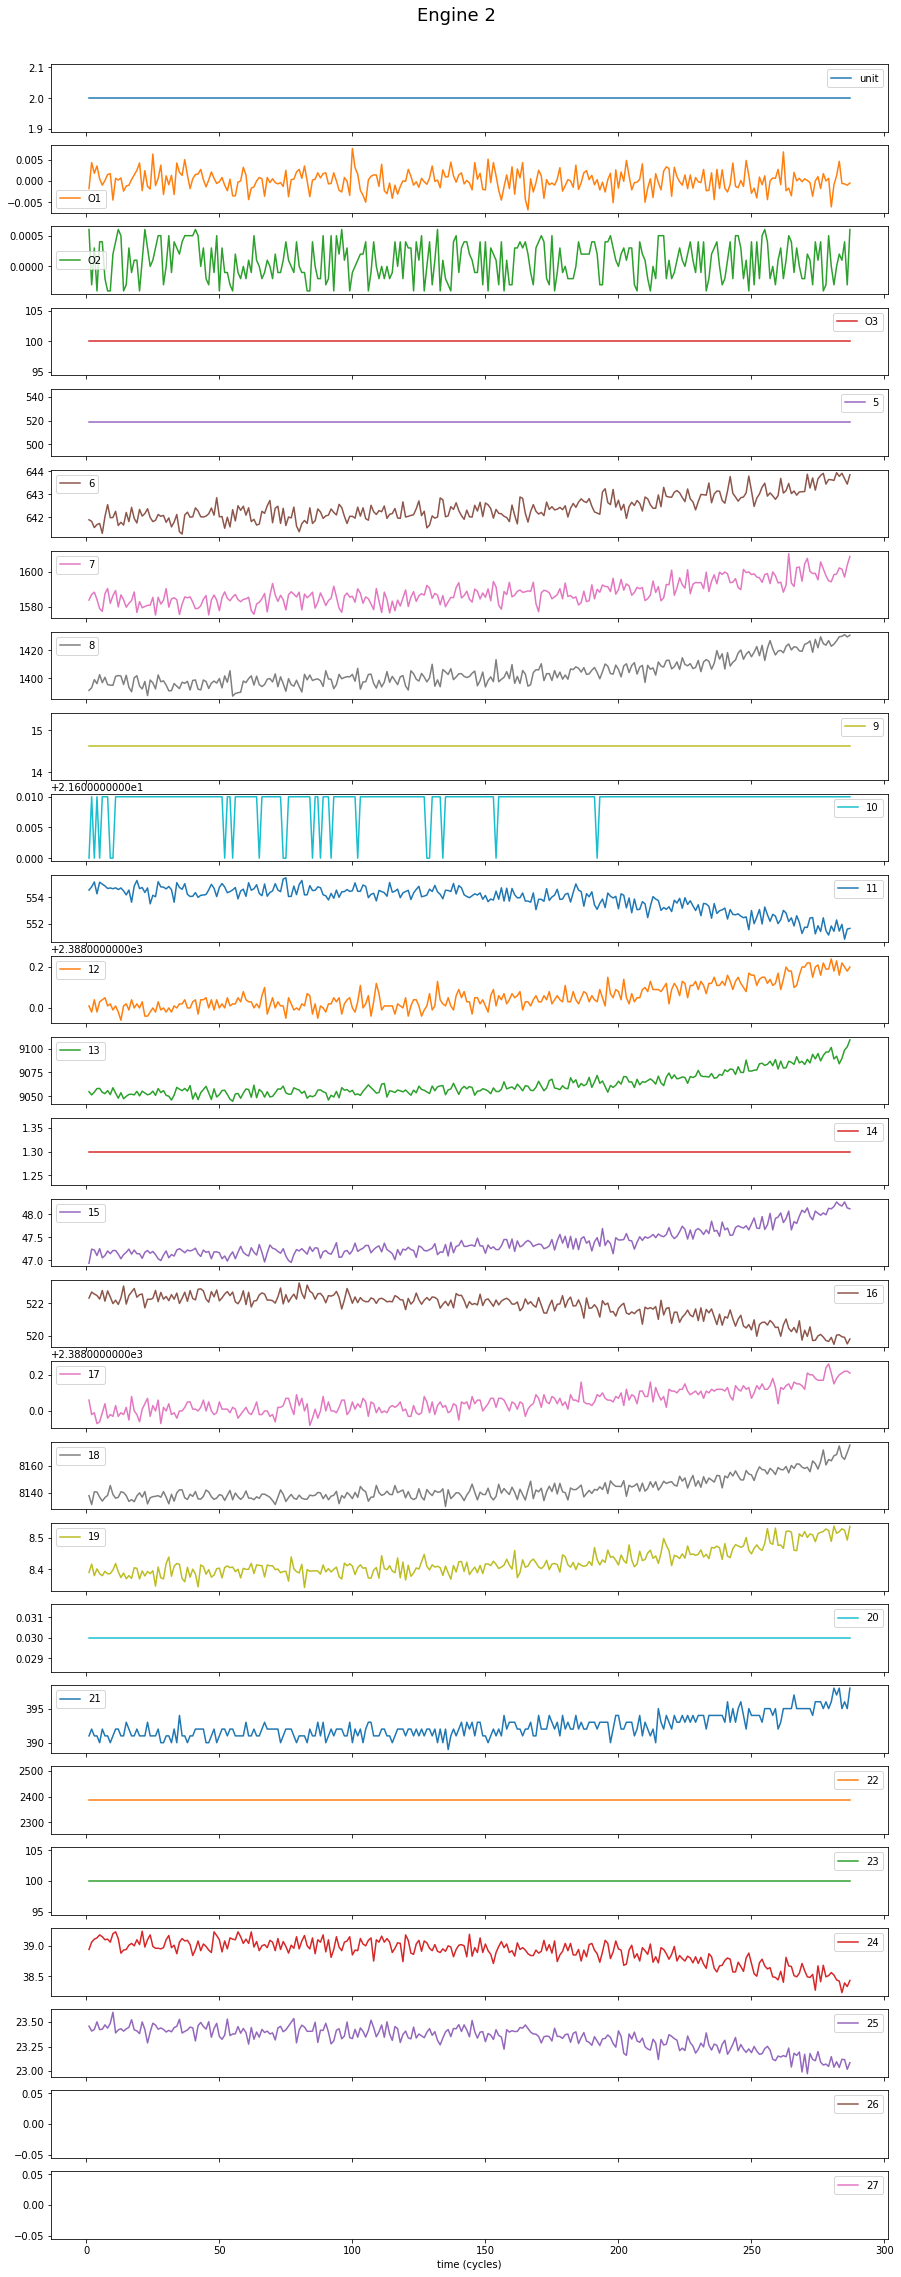

In [245]:
df_train.loc[df_train.unit == 2] \
    .set_index('time (cycles)') \
    .plot(subplots=True, sharex=True, figsize=(15,40));
plt.suptitle("Engine 2", y = 0.90, size = 18);

- We can see some sensors show clear trends towards the failure, but only part way through the time series
- Some sensors and settings are empty or constant
- Sensor 10 does not seem very informative


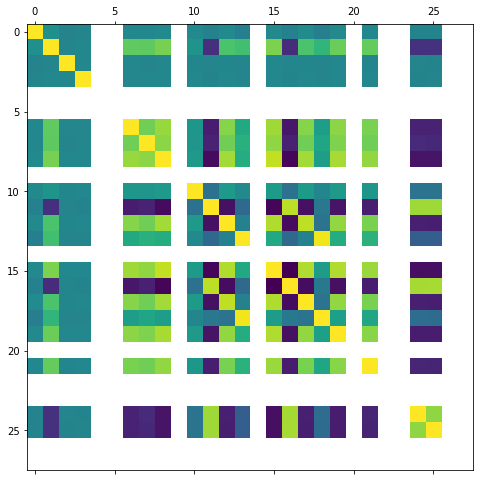

In [246]:
plt.figure(figsize=(8,8))
plt.matshow(df_train.corr(), fignum = 1)
plt.show()

The correlation plot above makes it clear that we have many variables which have no correlation with anything (most likely implying 0 variance as noted above). These should be identified and removed.

### Low/zero variance variable removal

In [247]:
df_train_red = df_train.loc[:, df_train.var() > 0.000000001]

In [248]:
df_train_red.columns

Index([         'unit', 'time (cycles)',            'O1',            'O2',
                     6,               7,               8,              10,
                    11,              12,              13,              15,
                    16,              17,              18,              19,
                    21,              24,              25],
      dtype='object')

In [295]:
df_test_red = df_test[[         'unit', 'time (cycles)',            'O1',            'O2',
                     6,               7,               8,              10,
                    11,              12,              13,              15,
                    16,              17,              18,              19,
                    21,              24,              25]]

In [249]:
df_train_red

,unit,time (cycles),O1,O2,6,7,8,10,11,12,13,15,16,17,18,19,21,24,25
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,21.61,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,21.61,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,21.61,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,21.61,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640


In [250]:
df_train_red.corr()

,unit,time (cycles),O1,O2,6,7,8,10,11,12,13,15,16,17,18,19,21,24,25
unit,1.000000,0.078753,-0.017895,-0.006197,0.014133,0.012621,0.026116,0.026431,-0.032073,0.039929,-0.052053,0.024707,-0.031882,0.044230,-0.059473,0.022486,0.013513,-0.020589,-0.016465
time (cycles),0.078753,1.000000,-0.004527,0.016132,0.549898,0.543947,0.624577,0.105980,-0.595914,0.475977,0.443999,0.634385,-0.611354,0.477523,0.370324,0.588676,0.566995,-0.583597,-0.585923
O1,-0.017895,-0.004527,1.000000,0.011660,0.009030,-0.005651,0.009544,-0.001340,-0.009437,-0.000427,-0.004279,0.011658,-0.001491,0.002318,-0.004469,0.007652,0.002599,-0.005713,-0.014559
O2,-0.006197,0.016132,0.011660,1.000000,0.007266,0.009068,0.014673,0.014355,-0.016678,0.013285,-0.005425,0.011690,-0.010923,0.018156,-0.006310,0.014156,0.012280,-0.010554,-0.007846
6,0.014133,0.549898,0.009030,0.007266,1.000000,0.602610,0.714949,0.132242,-0.702136,0.662325,0.273764,0.740020,-0.724578,0.661792,0.179752,0.675975,0.629886,-0.661841,-0.668050
7,0.012621,0.543947,-0.005651,0.009068,0.602610,1.000000,0.678413,0.116039,-0.664595,0.602481,0.322964,0.695900,-0.680307,0.600963,0.237137,0.639921,0.600017,-0.625941,-0.633901
8,0.026116,0.624577,0.009544,0.014673,0.714949,0.678413,1.000000,0.150480,-0.793130,0.746852,0.297429,0.830136,-0.815591,0.745158,0.190748,0.758459,0.703499,-0.748067,-0.745193
10,0.026431,0.105980,-0.001340,0.014355,0.132242,0.116039,0.150480,1.000000,-0.155720,0.152161,0.019347,0.160014,-0.155884,0.158276,-0.002112,0.149042,0.130810,-0.141419,-0.137419
11,-0.032073,-0.595914,-0.009437,-0.016678,-0.702136,-0.664595,-0.793130,-0.155720,1.000000,-0.767132,-0.217835,-0.822805,0.812713,-0.764611,-0.110053,-0.747051,-0.692893,0.736163,0.737447
12,0.039929,0.475977,-0.000427,0.013285,0.662325,0.602481,0.746852,0.152161,-0.767132,1.000000,-0.032091,0.782213,-0.786540,0.826084,-0.144787,0.700949,0.627785,-0.687030,-0.688840


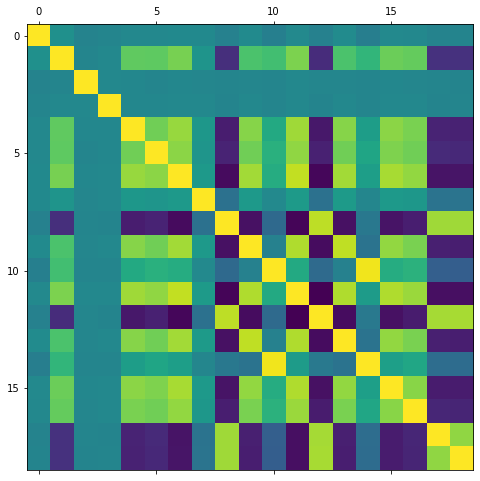

In [251]:
plt.figure(figsize=(8,8))
plt.matshow(df_train_red.corr(), fignum = 1)
plt.show()

We have the variables that were not bringing any information

In [252]:
df_train_red

,unit,time (cycles),O1,O2,6,7,8,10,11,12,13,15,16,17,18,19,21,24,25
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,21.61,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,21.61,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,21.61,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,21.61,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640


Now we can see that we have correlation values across the whole matrix.

## Dimensionality reduction

The problem statement mentioned that there is a significant amount of noise associated with the sensor data. Hence it may be wise to perform dimensionality reduction. PCA (Principal Components Analysis) allows us to do this by identifying which dimensions of the data capture most of the variance in the dataset.

This technique can be particularly useful when we have correlated variables as we appear to above.

**DECIDED NOT TO USE THIS AS WOULD MAKE INTERPRETABILITY MORE DIFFICULT**

In [158]:
# scale dataset
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train = sc.fit_transform(df_train_red)


/Users/sammacintyre/Documents/Careers/Analysis Tasks/Siemens Energy/sie-2021/siemens-ds-coding-test/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/sammacintyre/Documents/Careers/Analysis Tasks/Siemens Energy/sie-2021/siemens-ds-coding-test/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [160]:
from sklearn.decomposition import PCA
 
pca = PCA(0.95)
 
X_train = pca.fit_transform(X_train)
 
explained_variance = pca.explained_variance_ratio_

In [163]:
explained_variance

array([0.52857248, 0.12058445, 0.05624089, 0.05512948, 0.05345438,
       0.0248529 , 0.02288982, 0.02045329, 0.01919953, 0.01700027,
       0.01609811, 0.01415575, 0.01144369])

In [159]:
X_train

array([[-1.56517022, -0.31597968, -1.3729532 , ..., -0.78170979,
         1.34849274,  1.19442705],
       [-1.55065208,  0.87272193, -1.03172035, ..., -0.78170979,
         1.01652793,  1.23692196],
       [-1.53613393, -1.96187421,  1.01567674, ..., -2.07309423,
         0.73989059,  0.50342281],
       ...,
       [ 1.29490444,  0.18693254, -0.00802181, ...,  3.09244354,
        -2.08181033, -3.29248147],
       [ 1.30942258, -0.49885685,  1.01567674, ...,  1.15536688,
        -2.91172236, -2.08507166],
       [ 1.32394073, -1.458962  , -1.71418605, ...,  1.8010591 ,
        -2.46910261, -2.19408035]])

### Create the target variable

To create the target variable, must subtract current cycle from failure cycle. This is assuming a standard linear countdown RUL, which is generally not the realistic situation. A more complex anaysis could look at modelling the RUL as a piecewise function or as a polynomial.

In [253]:
# Create dataframe containing failure cycle for each unit
df_maxes = df_train_red.groupby('unit').max()['time (cycles)']

In [254]:
# Merge maxes to main_df
df_train_red = df_train_red.merge(df_maxes, on = 'unit')

Note that above we have some variables that have 0 variance. These should be removed as they contribute no useful information.

In [255]:
# Calculate target variable
df_train_red['Cycles to failure'] = df_train_red['time (cycles)_y'] - df_train_red['time (cycles)_x']

In [257]:
df_train_red

,unit,time (cycles)_x,O1,O2,6,7,8,10,11,12,...,15,16,17,18,19,21,24,25,time (cycles)_y,Cycles to failure
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,...,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,192,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,...,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,192,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,...,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,192,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,...,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,192,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,...,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,192,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,21.61,551.43,2388.19,...,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,200,4
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,21.61,550.86,2388.23,...,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,200,3
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,21.61,550.94,2388.24,...,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,200,2
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,21.61,550.68,2388.25,...,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,200,1


There are a few things to keep in mind here when it comes to how to model this problem. A simple approach may say that the time to failure can be predicted only based on the current conditions of the engine (no account of past settings or sensor values)

This seems overly simplistic given it is probable that past operating conditions affect the current state and hence future state.

Furthermore, some thought needs to be given to the importance of the difference of each unit. I see two main approaches:

1. Assume unit is irrelevant and the data can be treated as I.I.D (Indpendent and Identically Distributed). This is a relatively valid assumption given the information we have above.
2. Include the unit as a categorical variable, which should capture some of the inherent variation of the engines

On further reflection, I have disregarded the unit category, as this contains random information about the initial state of the engine (things that are not captured by age or other variables). This information is unlikely to be obtainable if we are wanting to make predictions in the future about unknown engines (outside of unit 1 - 100)


## Linear regression

Let's disregard unit specificity for the moment, and fit a simple linear regression forgetting cumulative data, to give us a benchmark model.

### Train and test split

As we do not have labels for the test set, we will perform an 80/20 training test split to be able to compare our models.

In [258]:
# Drop columns
df_target = df_train_red['Cycles to failure']

In [259]:
df_features = df_train_red.drop(['unit', 'time (cycles)_y', 'Cycles to failure'], axis = 1)

In [297]:
df_features_test = df_test_red.drop(['unit'], axis = 1)

In [261]:
df_target

0        191
1        190
2        189
3        188
4        187
        ... 
20626      4
20627      3
20628      2
20629      1
20630      0
Name: Cycles to failure, Length: 20631, dtype: int64

In [263]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(df_features.values, df_target.values, test_size = 0.2, random_state = 42)

In [264]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [266]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [267]:
model_LR = LinearRegression()
# fitting the training data
model_LR.fit(train_features, train_labels)

LinearRegression()

#### Metrics on the train set

In [268]:
# Obtain R squared as a measure of fit
r_sq = model_LR.score(train_features, train_labels)
print('coefficient of determination:', r_sq)

# Print the Intercept:
print('intercept:', model_LR.intercept_)

# Print the Slope:
print('coefficients:', model_LR.coef_) 

coefficient of determination: 0.6555299692097138
intercept: 129065.64355030509
coefficients: [-3.95289477e-01 -1.23946679e+01  3.07730887e+03 -5.72015441e+00
 -2.52027110e-01 -4.31919487e-01 -4.20026635e+02  4.77945618e+00
 -2.93636400e+01 -2.24140702e-01 -2.15904571e+01  6.48669439e+00
 -1.98859399e+01 -7.01028998e-02 -6.30412764e+01 -1.06693541e+00
  1.20780626e+01  2.34247151e+01]


We have obtained an R^{2} score of 0.66, which is not a particularly good fit.

#### Metrics on the 'test' set

In [270]:
y_pred = model_LR.predict(test_features)

In [271]:
errors = abs(y_pred - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 30.54


## Random Forest

Let's use a Random Forest to predict the survival time of the engine.

We will use the same train/test split as above

In [272]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (16504, 18)
Training Labels Shape: (16504,)
Testing Features Shape: (4127, 18)
Testing Labels Shape: (4127,)


In [273]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [274]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 25.34


### XGBoost

In [275]:
import xgboost as xgb


In [276]:
model_XG = xgb.XGBRegressor()

In [277]:
model_XG.fit(train_features, train_labels)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [278]:
# Use the forest's predict method on the test data
predictions = model_XG.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 26.68


## Try adding lags

In [280]:
train_features_lags = pd.concat([df_features, df_features.shift(), df_features.shift(2)], axis=1)

In [284]:
train_features_lags.dropna(inplace = True)

In [286]:
df_target_lags = df_target[2:]

In [288]:
# resplit data
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(train_features_lags.values, df_target_lags.values, test_size = 0.2, random_state = 42)

### RF

In [289]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [290]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 24.6


### XGBoost

In [291]:
model_XG = xgb.XGBRegressor()

In [292]:
model_XG.fit(train_features, train_labels)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [293]:
# Use the forest's predict method on the test data
predictions = model_XG.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 26.38


## Final predictions

The model with best MAE is the Random Forest using lags, so we will use this to predict on the test set.

#### Transform test dataset into correct form

In [294]:
df_features

,time (cycles)_x,O1,O2,6,7,8,10,11,12,13,15,16,17,18,19,21,24,25
0,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,196,-0.0004,-0.0003,643.49,1597.98,1428.63,21.61,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735
20627,197,-0.0016,-0.0005,643.54,1604.50,1433.58,21.61,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594
20628,198,0.0004,0.0000,643.42,1602.46,1428.18,21.61,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333
20629,199,-0.0011,0.0003,643.23,1605.26,1426.53,21.61,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640


In [303]:
df_features_test_lag = pd.concat([df_features_test, df_features_test.shift(), df_features_test.shift(2)], axis=1)

In [304]:
df_features_test_lag

,time (cycles),O1,O2,6,7,8,10,11,12,13,...,12,13,15,16,17,18,19,21,24,25
0,1,0.0023,0.0003,643.02,1585.29,1398.21,21.61,553.90,2388.04,9050.17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,21.61,554.85,2388.01,9054.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,0.0003,0.0001,642.46,1586.94,1401.34,21.61,554.11,2388.05,9056.96,...,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392.0,38.86,23.3735
3,4,0.0042,0.0000,642.44,1584.12,1406.42,21.61,554.07,2388.03,9045.29,...,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393.0,39.02,23.3916
4,5,0.0014,0.0000,642.51,1587.19,1401.92,21.61,554.16,2388.01,9044.55,...,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393.0,39.08,23.4166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,194,0.0049,0.0000,643.24,1599.45,1415.79,21.61,553.41,2388.02,9142.37,...,2388.05,9141.92,47.57,520.99,2388.07,8210.24,8.4171,395.0,38.77,23.2148
13092,195,-0.0011,-0.0001,643.22,1595.69,1422.05,21.61,553.22,2388.05,9140.68,...,2388.08,9139.88,47.58,521.37,2388.05,8213.57,8.4429,395.0,38.63,23.2952
13093,196,-0.0006,-0.0003,643.44,1593.15,1406.82,21.61,553.04,2388.11,9146.81,...,2388.02,9142.37,47.69,520.69,2388.00,8213.28,8.4715,394.0,38.65,23.1974
13094,197,-0.0038,0.0001,643.26,1594.99,1419.36,21.61,553.37,2388.07,9148.85,...,2388.05,9140.68,47.60,521.05,2388.09,8210.85,8.4512,395.0,38.57,23.2771


In [305]:
df_features_test_lag.dropna(inplace = True)

In [307]:
pred_final = rf.predict(df_features_test_lag.values)

In [308]:
pred_final

array([212.561, 208.357, 204.327, ...,  23.693,  23.757,  19.61 ])

In [314]:
pd.DataFrame(pred_final, columns = ['Expected time to failure (cycles)']).to_csv('final_predictions.csv')